### Sumário

- Teorema de Nyquist e Aliasing
- Sinal limitado em banda
- Espectro do sinal amostrado
- Amostrando abaixo do critério de Nyquist
- Conclusão

### Teorema de Nyquist e Aliasing

Neste tópico discutiremos o Teorema de Nyquist a o efeto de aliasing causado quando as condições do critério não são satisfeitas. Para começarmos vamos relembrar o que o teorema nos diz:

```
Se uma função x(t) (contínua) não possue frequências acima de um valor B, então esta será completamente representada por um série de pontos espaçãdos a 1/(2B).
```

Ou seja não perdemos informação ao amostrar o sinal x(t) se usar fum frequência de amostragem maior que 2B.

Podemos verificar esse fato observando o que acontece no domínio da frequência com o espectro de x(t) ao ser amostrado com uma frequência $f_s$. Supondo que o espectro de $x(t)$ é dado por $X(f)$ temos:


$X(f) = \int_{-\infty}^{\infty}{x(t)e^{(-i2\pi ft)}}dt$

O processo de amostragem no tempo pode ser modelado como a multiplicação do sinal $x(t)$ por um sequência de funções impulsos espaçados $\frac{1}{T_s}$. Onde $T_s$ é o tempo de amostragem.

$x_{sampled}(t) = x(t)\sum_{k=-\infty}^{k=\infty}\delta(t-kT_s)$, k inteiro

Portanto o espectro do sinal amostrado é dado pela convolução do espetro original de $x(t)$ convoluido com uma sequência de impulsos espaçados $f_s = \frac{1}{T_s}$. Isso tem o efeito de replicar o espectro de $x(t)$ a cada $f_s$ unidades de frequência, esse espectro replicado pode ser descrito pela equação:

$X_{sampled}(f) = X(f-kf_s)$

Caso a maior componente de frequência do nosso sinal seja B se usarmos um frequência de amostragem ($f_s$) menor que 2B, veremos que o espectro sinal amostrado ficara distorcido, pois será somado com as cópias de suas repetições, esse efeito de distorção devido a taxas de amostragem inadequada é chamado de **aliasing**. 

A seguir vamos verificar gráficamente o efeito de aliasing usando numpy. 

### Sinal limitado em banda

Primeiro, devemos lembrar que o o sinal $x(t)$ é contínuo e não conseguimos representar um sinal contínuo num ambiente digital com mémoria finita. Portante vamos aproximar nosso sinal discretizando-o com uma alta frequência de amostragem, bem acima da frequência mínima para satisfazer o critério de Nyquist.


Em nosso exemplo vamos definir um sinal com espectro limitado em frequência, neste tópico usaremos um sinal senoidal cuja frequência varia linearmente entre valores $f_{min}$ e $f_{max}$.  Tal sinal pode ser descrito pela equação:

$y = sin(2\pi(ct^2 + f_{min}))$

Para confirmar que a frequência desse sinal de fato muda lienarmente vamos ver a derivada da fase da senoide:

$\frac{d\phi}{dt} = 2ct$

Ou seja a frequência varia linearmente de forma proporcional a constante c, se quiser que num instante $t_{final}$ a frequência seja $f_{max}$ temos:

$c = \frac{f_{max}}{2t_{final}}$

Vamos calcular e ver este sinal e seu espectro

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Fs = 1000
tfinal = 2
fmin = 10
fmax = 20

In [3]:
def get_linear_chirp(fs, fmin, fmax, tfinal):
  freq_lin_coef = fmax/(2*tfinal)
  t = np.arange(0, tfinal, 1/fs)
  return np.sin(2*np.pi*(freq_lin_coef*t**2+fmin)), t

In [4]:
y, t = get_linear_chirp(Fs, fmin, fmax, tfinal)

In [5]:
y_fft = np.fft.fft(y)
y_fftp = np.abs(y_fft)/np.linalg.norm(np.abs(y_fft))
y_fft_hamming = np.fft.fft(y)
y_fftp_hamming = np.abs(y_fft_hamming)/np.linalg.norm(np.abs(y_fft_hamming))
freq = np.fft.fftfreq(len(y_fft))*Fs

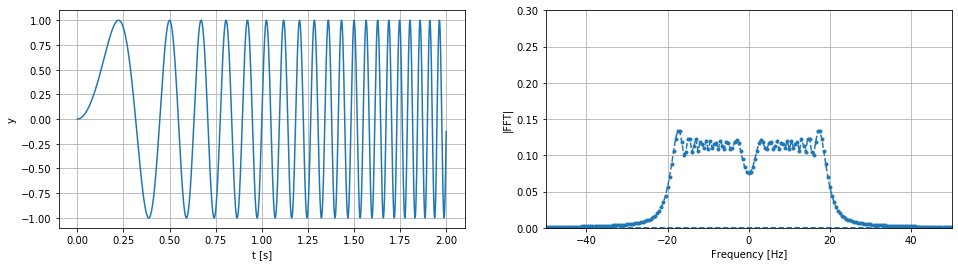

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(t, y)
axs[0].set_ylabel("y")
axs[0].set_xlabel("t [s]")
axs[0].grid()
axs[1].plot(freq, y_fftp, '.--')
axs[1].set_ylim([0, 0.3])
axs[1].set_xlim([-50, 50])
axs[1].set_ylabel("|FFT|")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].grid()

Como vemos acima nosso sinal de fato tem espectro limitado as frequêncuas de -20 Hz e 20 Hz como era esperado.

### Espectro do sinal amostrado

Vamos agora olhar o espectro desse sinal convoluindo-o com um sequencia de impulsos espelhados $f$ Hz e ver o comportamento do espectro.

In [7]:
y_fftp = np.fft.fftshift(y_fftp)
freq = np.fft.fftshift(freq)

In [8]:
def repeat_spectrum(fft, fs, freq_distance, init_freq_range=50):
  length_per_herts = fs/len(fft)
  original_spec_freq = 0.5*fs/length_per_herts

  initial_length = int(init_freq_range/length_per_herts)
  impulse_distance = int(freq_distance/length_per_herts)
  
  impulse = np.zeros(2*initial_length+2*impulse_distance)
  impulse[np.arange(initial_length, len(impulse), impulse_distance)]  = 1

  spec = np.convolve(fft, impulse, 'same')
  spec_center = len(spec)//2
  return spec[spec_center-initial_length-impulse_distance:spec_center+initial_length+impulse_distance]

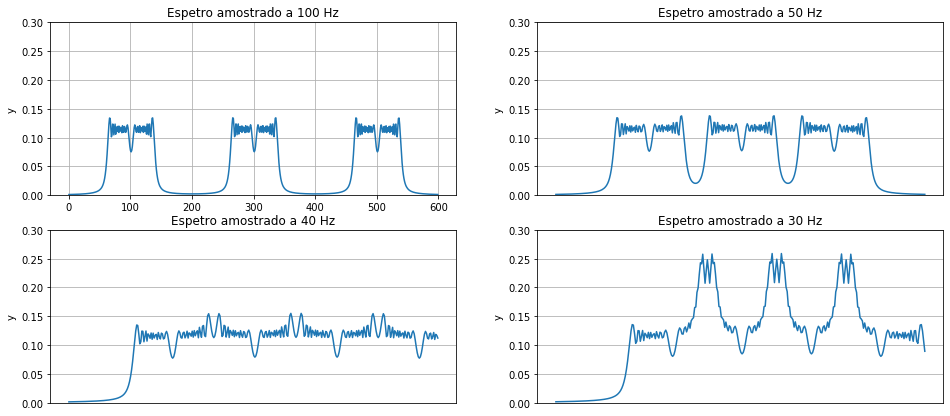

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7))
axs[0, 0].plot(repeat_spectrum(y_fftp, Fs, 100))
axs[0, 0].set_title("Espetro amostrado a 100 Hz")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_ylim([0, 0.3])
#axs[0, 0].set_xticks([])
axs[0, 0].grid()
axs[0, 1].plot(repeat_spectrum(y_fftp, Fs, 50))
axs[0, 1].set_title("Espetro amostrado a 50 Hz")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_ylim([0, 0.3])
axs[0, 1].set_xticks([])
axs[0, 1].grid()
axs[1, 0].plot(repeat_spectrum(y_fftp, Fs, 40))
axs[1, 0].set_title("Espetro amostrado a 40 Hz")
axs[1, 0].set_ylabel("y")
axs[1, 0].set_ylim([0, 0.3])
axs[1, 0].set_xticks([])
axs[1, 0].grid()
axs[1, 1].plot(repeat_spectrum(y_fftp, Fs, 30))
axs[1, 1].set_title("Espetro amostrado a 30 Hz")
axs[1, 1].set_ylabel("y")
axs[1, 1].set_ylim([0, 0.3])
axs[1, 1].set_xticks([])
axs[1, 1].grid()

Como podemos ver as repetições do espéctro se mantem iguais ao original até bem proximo ao limite do teorema de Nyquist, nestes casos para recuperamos o sinal bastaria filtrar o sinal amostrado com um filtro passa baixa mantendo somente uma das repeteções. 

Já quando usamos um frequência de amostragem abaixo do critério de Nyquist como por exemplo 30 Hz, as repetições do espectro ficam distorcidas e não mais podemos recuperar o sinal original.

### Amostrando abaixo do critério de Nyquist

Por fim, vamos analisar o nosso espectro obtido através da FFT  quando amostramos o sinal com uma frequência de amostragem de 30 Hz, é importante lembrar que ao diminuir a frequência de amostragem também diminuímos a faixa de frequência para a qual calculamos o espectro e portanto so observeramos a faixas de frequência entre -15 Hz e 15 Hz.

In [18]:
Fs = 30

In [19]:
y, t = get_linear_chirp(Fs, fmin, fmax, tfinal)

In [20]:
y_fft = np.fft.fft(y, n=1000)
y_fftp = np.abs(y_fft)/np.linalg.norm(np.abs(y_fft))
freq = np.fft.fftfreq(len(y_fft))*Fs

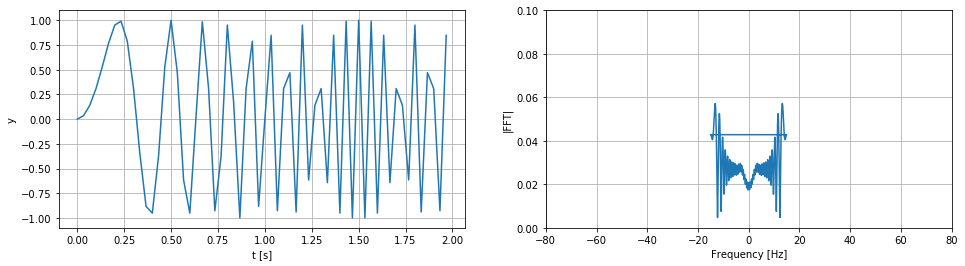

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(t, y)
axs[0].set_ylabel("y")
axs[0].set_xlabel("t [s]")
axs[0].grid()
axs[1].plot(freq, y_fftp)
axs[1].set_xlim([-80, 80])
axs[1].set_ylim([0, 0.1])
axs[1].set_ylabel("|FFT|")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].grid()

Embora somente vemos o espectro numa pequena faixa de frequência ao comparar o espectro obtido com a imagem anterior do espectro amostrado a 30 Hz vemos que ambos representam o espectro distorcido pelo efeito de aliasing.

### Conclusão

Neste tópicos discutimos:

- O teorema de Nyquist e efeito de aliasing
- A definição de um sinal limitado em banda
- O espectro de um sinal amostrado
- Espectro de um sinal sub amostrado